In [24]:
%matplotlib inline

import time
import serial
import struct
import numpy as np

from matplotlib import pyplot as plt

s = serial.Serial(port='/dev/tty.usbserial-0001', baudrate=500000, timeout=1)

registers = {
    'angle_limit': (0, 'ii', 'rw'),
    'temperature_shutdown': (1, 'f', 'rw'),
    'present_position': (10, 'i', 'r'),
    'goal_position': (20, 'i', 'rw'),
    'torque_enable': (30, '?', 'rw'),
    'pid': (31, 'fff', 'rw'),
    'temperature': (32, 'f', 'r'),
}

def send_msg(io, id, instr, verbose):
    header = bytearray([0xff, 0xff, id, len(instr) + 1])
        
    msg = header + instr
    crc = 255 - sum(msg[2:]) % 256
    msg = msg + bytearray([crc])

    if verbose:
        print('Sending "{}"'.format(' '.join([hex(x) for x in msg])))
        
    io.write(msg)
    
    header = io.read(4)
    _, _, id, length = header
    status = io.read(length)
    
    msg = header + status
    if verbose:
        print('Got "{}"'.format(' '.join([hex(x) for x in msg])))
        
    err = msg[4]
    if err != 0:
        raise Exception('ERROR', err)
        
    time.sleep(0.001)
    
    return msg

def send_ping(io, id, verbose=False):
    _ = send_msg(io, id, bytearray([0x01]), verbose)

def send_read(io, id, reg, verbose=False):
    addr, datafmt, perm = registers[reg]
    msg = send_msg(io, id, bytearray([0x02, addr, 0x01]), verbose)

    if 'r' not in perm:
        raise ValueError(f'Register "{reg}" is write only!')

    payload = msg[5:-1]
    
    val = list(struct.unpack(3 * datafmt, payload))
    if len(datafmt) > 1:
        val = np.array(val).reshape(len(datafmt), -1).tolist()
    return val

def send_write(io, id, reg, values, verbose=False):
    addr, datafmt, perm = registers[reg]

    if 'w' not in perm:
        raise ValueError(f'Register "{reg}" is read only!')

    coded_values = struct.pack(
        datafmt * 3,
        *np.array(values).flatten().tolist()
    )
        
    _ = send_msg(io, id, bytearray([0x03, addr]) + coded_values, verbose)

In [4]:
send_ping(s, 40, verbose=True)

Sending "0xff 0xff 0x28 0x2 0x1 0xd4"
Got "0xff 0xff 0x28 0x2 0x0 0xd5"


In [5]:
l = []

for _ in range(100):
    t0 = time.time()
    send_ping(s, 40, verbose=False)
    t1 = time.time()
    l.append(t1 - t0)
    
np.mean(l) * 1000, np.std(l) * 1000

(1.8756842613220215, 0.09352951302102538)

In [6]:
print('ping', send_ping(s, id=40, verbose=False))

for reg in registers.keys():
    val = send_read(s, 40, reg)
    print(f'{reg.capitalize()}: {val}')

ping None
Angle_limit: [[-12888, 12888, -12888], [12888, -12888, 12888]]
Temperature_shutdown: [50.0, 50.0, 50.0]
Present_position: [18328, 15921, 29066]
Goal_position: [0, 0, 0]
Torque_enable: [False, False, False]
Pid: [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
Temperature: [0.0, 0.0, 0.0]


In [7]:
print(send_read(s, 40, 'goal_position'))
send_write(s, 40, 'goal_position', [10, 0, 30])
print(send_read(s, 40, 'goal_position'))

[0, 0, 0]
[10, 0, 30]


In [8]:
print(send_read(s, 40, 'pid'))
send_write(s, 40, 'pid', [[1.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.5, 0.0001, 0.0]])
print(send_read(s, 40, 'pid'))

[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
[[1.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.5, 9.999999747378752e-05, 0.0]]


In [9]:
print(send_read(s, 40, 'torque_enable'))
send_write(s, 40, 'torque_enable', [False, True, False])
print(send_read(s, 40, 'torque_enable'))

[False, False, False]
[False, True, False]


In [10]:
send_write(s, 40, 'torque_enable', [True, True, True])

In [11]:
send_read(s, 40, 'temperature')

[0.0, 0.0, 0.0]

In [12]:
l = []

t0 = time.time()

for _ in range(10000):
    send_write(s, 40, 'goal_position', [10, 0, 30])
    send_read(s, 40, 'present_position')

    t = time.time()
    dt = t - t0

    sleep_time = (0.01 - dt) - 0.001

    if sleep_time > 0:
        time.sleep(sleep_time)
    
    t0 = time.time()
    l.append(time.time())

(array([ 945.,  788.,  555.,  481.,  513.,  519., 2292., 3257.,  527.,
         122.]),
 array([0.00900984, 0.00913656, 0.00926328, 0.00939   , 0.00951672,
        0.00964344, 0.00977015, 0.00989687, 0.01002359, 0.01015031,
        0.01027703]),
 <BarContainer object of 10 artists>)

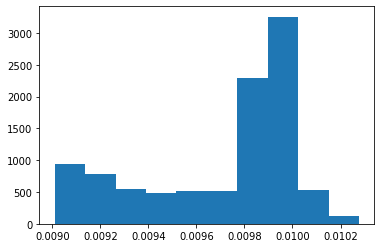

In [14]:
plt.figure()
plt.hist(np.diff(l))

In [ ]:
i = 0

In [22]:
s.flush()

In [25]:
while True:
    send_write(s, 40, 'goal_position', [10, 0, 30])
    send_read(s, 40, 'present_position')
    
    i += 1

SerialException: read failed: [Errno 6] Device not configured

In [16]:
i

330737